In this notebook, we explore several expansions of the score function. 
We'd like to find what is the correct theory that explains why linear score of Gaussian is a surprisingly good approximation of "exact" score than we expected. 

### Load datasets

In [8]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='~/Datasets', train=True, transform=transform, download=False)
test_dataset = torchvision.datasets.MNIST(root='~/Datasets', train=False, transform=transform)

# Create data loaders
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [3]:
Xtsr = torch.tensor(train_dataset.data)
Xtsr.unsqueeze_(1)
ytsr = torch.tensor(train_dataset.targets)
Xtsr = Xtsr.float() / 255.0
Xmat = Xtsr.view(Xtsr.shape[0], -1)
# Xmat = (Xmat - 0.5) / 0.5
imgshape = tuple(Xtsr.shape[1:])
print(imgshape)

/tmp/ipykernel_3179662/2452248127.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtsr = torch.tensor(train_dataset.data)
/tmp/ipykernel_3179662/2452248127.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytsr = torch.tensor(train_dataset.targets)


(1, 28, 28)


In [4]:
Xmean = Xmat.mean(dim=0)
Xcov = torch.cov(Xmat.T, )

In [5]:
Xmean = Xmat.mean(dim=0)
Xcov = (Xmat - Xmean).T @ (Xmat - Xmean) / Xmat.shape[0]

In [6]:
eigvals, eigvecs = torch.linalg.eigh(Xcov)
eigvals = torch.flip(eigvals, dims=(0,))
eigvecs = torch.flip(eigvecs, dims=(1,))
print(eigvals.shape, eigvecs.shape)

torch.Size([784]) torch.Size([784, 784])


In [ ]:
eigvals[0:10].sqrt()

tensor([2.2621, 1.9343, 1.8035, 1.6857, 1.6022, 1.5079, 1.3135, 1.2331, 1.2068,
        1.1148])

In [7]:
# sample noised data 
def sample_Xt_batch(Xmat, batch_size, sigma=0.01):
    idx = torch.randint(Xmat.shape[0], (batch_size,))
    Xt = Xmat[idx, :]
    Xt = Xt + sigma * torch.randn_like(Xt)
    return Xt

def sample_Xtyt_batch(Xmat, ytsr, batch_size, sigma=0.01):
    idx = torch.randint(Xmat.shape[0], (batch_size,))
    Xt = Xmat[idx, :]
    Xt = Xt + sigma * torch.randn_like(Xt)
    return Xt, ytsr[idx]

## Score Comparison: GMM vs analytical

### Analytical Score versions

In this section, we define various approximate score and see in practise, which of them are good approximators of neural score.

In [9]:
# define score approximators 
def mean_isotropic_score(Xt, Xmean, sigma, sigma0=0.0):
    score = (Xmean[None,] - Xt) / (sigma**2 + sigma0**2)
    return score

def Gaussian_score(Xt, Xmean, Xcov, sigma):
    cov_inv = torch.inverse(Xcov + torch.eye(Xcov.shape[0], device=Xcov.device) * sigma**2)
    score = torch.matmul((Xmean[None,] - Xt), cov_inv)
    return score

def Gaussian_1stexpens_score(Xt, Xmean, Xcov, sigma):
    cov_inv_1stexp = (torch.eye(Xcov.shape[0], device=Xcov.device) - Xcov / sigma**2) / sigma**2
    score = torch.matmul((Xmean[None,] - Xt), cov_inv_1stexp)
    return score

def Gaussian_2ndexpens_score(Xt, Xmean, Xcov, sigma):
    cov_inv_2ndexp = (torch.eye(Xcov.shape[0], device=Xcov.device) - Xcov / sigma**2 + Xcov @ Xcov / sigma**4) / sigma**2
    score = torch.matmul((Xmean[None,] - Xt), cov_inv_2ndexp)
    return score

def Gaussian_1stexpens_regularize_score(Xt, Xmean, Xcov, sigma, shift=None):
    # varmean = torch.trace(Xcov) / Xcov.shape[0]
    varsum = torch.trace(Xcov) / 2
    cov_inv_1stexp = (torch.eye(Xcov.shape[0], device=Xcov.device) - Xcov / (varsum + sigma**2)) / sigma**2
    score = torch.matmul((Xmean[None,] - Xt), cov_inv_1stexp)
    return score

def Gaussian_2ndexpens_regularize_score(Xt, Xmean, Xcov, sigma, shift=None):
    varsum = torch.trace(Xcov) / 2
    cov_inv_2ndexp = (torch.eye(Xcov.shape[0], device=Xcov.device) - Xcov / (varsum + sigma**2) + Xcov @ Xcov / (varsum + sigma**2)**2) / sigma**2
    score = torch.matmul((Xmean[None,] - Xt), cov_inv_2ndexp)
    return score

def delta_GMM_score(Xt, Xmat, sigma, return_weights=False):
    # get squared distance matrix
    sqdist = torch.cdist(Xt, Xmat, p=2) ** 2
    weights = F.softmax(-sqdist / (2 * sigma**2), dim=1)
    score = (torch.matmul(weights, Xmat) - Xt) / sigma**2
    if return_weights:
        return score, weights
    else:
        return score


def delta_GMM_crossterm_score(Xt, Xmat, sigma, return_weights=False):
    """Drop the sample norm term in the softmax. 
    basically assuming all sample have same distance to the mean """
    Xmean = Xmat.mean(dim=0)
    cross_terms = (Xt - Xmean) @ (Xmat - Xmean).t() / sigma ** 2
    # get squared distance matrix
    weights = F.softmax(cross_terms, dim=1)
    score = (torch.matmul(weights, Xmat) - Xt) / sigma**2
    if return_weights:
        return score, weights
    else:
        return score


def delta_GMM_crossterm_gaussequiv_score(Xt, Xmat, Xmean, Xcov, sigma, return_weights=False):
    """Drop the sample norm term in the softmax. 
    basically assuming all sample have same distance to the mean """
    precmat = torch.inverse(Xcov + torch.eye(Xcov.shape[0], device=Xcov.device) * sigma**2)
    cross_terms = (Xt - Xmean) @ precmat @ (Xmat - Xmean).t() # / sigma ** 2
    # get squared distance matrix
    weights = cross_terms / Xmat.shape[0]
    # score = (torch.matmul(weights, Xmat) - Xt) / sigma**2
    # TODO: Note this is different from the formula above! the formula above is much worse approxiamtion
    # the one below is totally and numerically equivalent to the Gaussian score
    score = (Xmean - Xt) / sigma**2 + torch.matmul(weights, Xmat - Xmean) / sigma**2
    if return_weights:
        return score, weights
    else:
        return score

def delta_GMM_crossterm_1stexpand_score(Xt, Xmat, Xmean, Xcov, sigma, return_weights=False):
    """This shall be equivalent to the Gaussian 1st expansion score"""
    cross_terms = (Xt - Xmean) @ (Xmat - Xmean).t() / sigma ** 2
    # mf_normalizer = torch.einsum("ij,Bi,Bj->B", Xcov, 
    #                              (Xt - Xmean), 
    #                              (Xt - Xmean)) / sigma ** 4
    # get squared distance matrix
    weights = (1 + cross_terms) / Xmat.shape[0]
    # score = (torch.matmul(weights, Xmat) - Xt) / sigma**2
    score = (Xmean - Xt) / sigma**2 + torch.matmul(weights, Xmat - Xmean) / sigma**2
    if return_weights:
        return score, weights
    else:
        return score

def delta_GMM_crossterm_approx_score(Xt, Xmat, Xmean, Xcov, sigma, return_weights=False):
    """Apply mean field approximation to the normalization factor, 
    keep the cross term on top."""
    cross_terms = (Xt - Xmean) @ (Xmat - Xmean).t() / sigma ** 2
    mf_normalizer = torch.einsum("ij,Bi,Bj->B", Xcov, 
                                 (Xt - Xmean), 
                                 (Xt - Xmean)) / sigma ** 4
    # get squared distance matrix
    weights = (cross_terms - mf_normalizer[:, None] / 2).exp() / Xmat.shape[0]
    # score = (torch.matmul(weights, Xmat) - Xt) / sigma**2
    score = (Xmean - Xt) / sigma**2 + torch.matmul(weights, Xmat - Xmean) / sigma**2
    if return_weights:
        return score, weights
    else:
        return score


def delta_GMM_crossterm_approx_noexp_score(Xt, Xmat, Xmean, Xcov, sigma):
    """Apply mean field approximation to the normalization factor, 
    keep the cross term on top."""
    cross_terms = (Xt - Xmean) @ (Xmat - Xmean).t() / sigma ** 2
    mf_normalizer = torch.einsum("ij,Bi,Bj->B", Xcov, 
                                 (Xt - Xmean), 
                                 (Xt - Xmean)) / sigma ** 4
    # get squared distance matrix
    weights = (cross_terms - mf_normalizer[:, None] / 2) / Xmat.shape[0]
    # score = (torch.matmul(weights, Xmat) - Xt) / sigma**2
    score = (Xmean - Xt) / sigma**2 + torch.matmul(weights, Xmat - Xmean) / sigma**2
    return score


def delta_GMM_nearest_score(Xt, Xmat, sigma):
    """Find the nearest neighbor in dataset and attract to it. So the Softmax is actually one hot."""
    # get squared distance matrix
    sqdist = torch.cdist(Xt, Xmat, p=2) ** 2
    # effective one hot weight
    weights = F.softmax(-sqdist / (2 * 0.0001 ** 2), dim=1)
    score = (torch.matmul(weights, Xmat) - Xt) / sigma**2
    # score = (Xmean - Xt) / sigma**2 + torch.matmul(weights, Xmat - Xmean) / sigma**2
    return score


def delta_GMM_rndweights_score(Xt, Xmat, sigma):
    """ Use normalized uniform random number as Softmax weights """
    # get squared distance matrix
    sqdist = torch.cdist(Xt, Xmat, p=2) ** 2
    # random weights that sum up to one.
    weights = torch.rand_like(sqdist)
    weights = weights / weights.sum(dim=1, keepdim=True)
    score = (torch.matmul(weights, Xmat) - Xt) / sigma**2
    # score = (Xmean - Xt) / sigma**2 + torch.matmul(weights, Xmat - Xmean) / sigma**2
    return score

def delta_GMM_rndsample_score(Xt, Xmat, sigma):
    """ Use normalized uniform random number as Softmax weights """
    # get squared distance matrix
    sqdist = torch.cdist(Xt, Xmat, p=2) ** 2
    # random weights that sum up to one.
    weights = torch.rand_like(sqdist)
    weights = F.softmax(weights / (2 * 0.0001 ** 2), dim=1)
    score = (torch.matmul(weights, Xmat) - Xt) / sigma**2
    return score

In [10]:
var_avg = torch.trace(Xcov) / Xcov.shape[0]

In [11]:
# set pandas display
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [18]:
import pandas as pd
def explained_var(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum() / vec1.pow(2).sum()

def explained_var_vec(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum(dim=-1) / vec1.pow(2).sum(dim=-1)

device = "cuda"
Xmat = Xmat.to(device)
Xmean = Xmat.mean(dim=0)
Xcov = torch.cov(Xmat.T, ) + torch.eye(Xmat.shape[1], device=Xmat.device) * 1e-5
std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()
print("Sample probes according to distribution of X_t. ")
df_all = []
for sigma in [0.02, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0]:
    Xt = sample_Xt_batch(Xmat, 2000, sigma=sigma)
    score_mean_Xt = mean_isotropic_score(Xt, Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, Xmean, sigma, sigma0=std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, Xmean, Xcov, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, Xmean, Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, Xmean, Xcov, sigma)
    score_gaussian1st_regul_Xt = Gaussian_1stexpens_regularize_score(Xt, Xmean, Xcov, sigma)
    score_gaussian2nd_regul_Xt = Gaussian_2ndexpens_regularize_score(Xt, Xmean, Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, Xmat, sigma)
    score_gmm_crossterm_Xt = delta_GMM_crossterm_score(Xt, Xmat, sigma)
    score_gmm_crossterm1st_Xt = delta_GMM_crossterm_1stexpand_score(Xt, Xmat, Xmean, Xcov, sigma)
    score_gmm_cross_approx_Xt = delta_GMM_crossterm_approx_score(Xt, Xmat, Xmean, Xcov, sigma)
    score_gmm_cross_noexp_approx_Xt = delta_GMM_crossterm_approx_noexp_score(Xt, Xmat, Xmean, Xcov, sigma)
    score_gmm_cross_gaussEquiv_Xt =  delta_GMM_crossterm_gaussequiv_score(Xt, Xmat, Xmean, Xcov, sigma)
    score_gmm_nearest_Xt = delta_GMM_nearest_score(Xt, Xmat, sigma)
    score_gmm_rndweights_Xt = delta_GMM_rndweights_score(Xt, Xmat, sigma)
    score_gmm_rndsample_Xt = delta_GMM_rndsample_score(Xt, Xmat, sigma)
    print(f"sigma={sigma}")
    df_col = []
    for name, score in [("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gaussian 1st expansion regularized", score_gaussian1st_regul_Xt),
                        ("gaussian 2nd expansion regularized", score_gaussian2nd_regul_Xt),
                        ("GMM nearest", score_gmm_nearest_Xt), 
                        ("GMM data rnd weighted", score_gmm_rndweights_Xt),
                        ("GMM data rnd sampled", score_gmm_rndsample_Xt),
                        ("GMM crossterm softmax", score_gmm_crossterm_Xt), 
                        ("GMM crossterm softmax 1st expand", score_gmm_crossterm1st_Xt),
                        ("GMM crossterm softmax mean field normalizer approx", score_gmm_cross_approx_Xt), 
                        ("GMM crossterm softmax mean field normalizer noexp approx", score_gmm_cross_noexp_approx_Xt), 
                        ("GMM crossterm gauss equivalent", score_gmm_cross_gaussEquiv_Xt)
                        # ("GMM", score_gmm_Xt), 
                        ]:
        exp_var_vec = explained_var_vec(score_gmm_Xt, score)
        exp_var_rev_vec = explained_var_vec(score, score_gmm_Xt)
        # print(f" {name}\tExp.Var.{exp_var_vec.mean().item()} "\
        #       f"\t rev Exp.Var.={exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
        df_col.append({"sigma": sigma, "name": name, "exp_var": exp_var_vec.mean().item(), "rev_exp_var": exp_var_rev_vec.mean().item()})
    print(pd.DataFrame(df_col))
    df_all.append(pd.DataFrame(df_col))
df_all = pd.concat(df_all)

Sample probes according to distribution of X_t. 
sigma=0.02
    sigma                                               name       exp_var   rev_exp_var
0    0.02                                     mean isotropic -1.687468e+02  6.452810e-03
1    0.02                               mean + std isotropic  5.985257e-03 -1.784686e+02
2    0.02                                           gaussian  3.429559e-01 -1.093165e+00
3    0.02                             gaussian 1st expansion -5.981686e+09 -1.202524e-07
4    0.02                             gaussian 2nd expansion -6.434604e+17  0.000000e+00
5    0.02                 gaussian 1st expansion regularized -1.478610e+02  7.290408e-03
6    0.02                 gaussian 2nd expansion regularized -1.502345e+02  7.180023e-03
7    0.02                                        GMM nearest  1.000000e+00  1.000000e+00
8    0.02                              GMM data rnd weighted -1.687463e+02  6.452877e-03
9    0.02                               GMM data r

In [20]:
import pandas as pd
def explained_var(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum() / vec1.pow(2).sum()

def explained_var_vec(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum(dim=-1) / vec1.pow(2).sum(dim=-1)

device = "cuda"
Xmat = Xmat.to(device)
Xmean = Xmat.mean(dim=0)
Xcov = torch.cov(Xmat.T, ) + torch.eye(Xmat.shape[1], device=Xmat.device) * 1e-5
std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()
print("Sample probes according to distribution of X_t. ")
df_all = []
for sigma in [0.02, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0]:
    Xt = sample_Xt_batch(Xmat, 2000, sigma=sigma)
    score_mean_Xt = mean_isotropic_score(Xt, Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, Xmean, sigma, sigma0=std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, Xmean, Xcov, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, Xmean, Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, Xmean, Xcov, sigma)
    score_gaussian1st_regul_Xt = Gaussian_1stexpens_regularize_score(Xt, Xmean, Xcov, sigma)
    score_gaussian2nd_regul_Xt = Gaussian_2ndexpens_regularize_score(Xt, Xmean, Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, Xmat, sigma)
    score_gmm_crossterm_Xt = delta_GMM_crossterm_score(Xt, Xmat, sigma)
    score_gmm_crossterm1st_Xt = delta_GMM_crossterm_1stexpand_score(Xt, Xmat, Xmean, Xcov, sigma)
    score_gmm_cross_approx_Xt = delta_GMM_crossterm_approx_score(Xt, Xmat, Xmean, Xcov, sigma)
    score_gmm_cross_noexp_approx_Xt = delta_GMM_crossterm_approx_noexp_score(Xt, Xmat, Xmean, Xcov, sigma)
    score_gmm_cross_gaussEquiv_Xt =  delta_GMM_crossterm_gaussequiv_score(Xt, Xmat, Xmean, Xcov, sigma)
    score_gmm_nearest_Xt = delta_GMM_nearest_score(Xt, Xmat, sigma)
    score_gmm_rndweights_Xt = delta_GMM_rndweights_score(Xt, Xmat, sigma)
    score_gmm_rndsample_Xt = delta_GMM_rndsample_score(Xt, Xmat, sigma)
    print(f"sigma={sigma}")
    df_col = []
    for name, score in [("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gaussian 1st expansion regularized", score_gaussian1st_regul_Xt),
                        ("gaussian 2nd expansion regularized", score_gaussian2nd_regul_Xt),
                        ("GMM", score_gmm_Xt),
                        ("GMM nearest", score_gmm_nearest_Xt), 
                        ("GMM data rnd weighted", score_gmm_rndweights_Xt),
                        ("GMM data rnd sampled", score_gmm_rndsample_Xt),
                        ("GMM crossterm softmax", score_gmm_crossterm_Xt), 
                        ("GMM crossterm softmax 1st expand", score_gmm_crossterm1st_Xt),
                        ("GMM crossterm softmax mean field normalizer approx", score_gmm_cross_approx_Xt), 
                        ("GMM crossterm softmax mean field normalizer noexp approx", score_gmm_cross_noexp_approx_Xt), 
                        ("GMM crossterm gauss equivalent", score_gmm_cross_gaussEquiv_Xt)
                        # ("GMM", score_gmm_Xt), 
                        ]:
        exp_var_vec = explained_var_vec(score_gaussian_Xt, score)
        exp_var_rev_vec = explained_var_vec(score, score_gaussian_Xt)
        # print(f" {name}\tExp.Var.{exp_var_vec.mean().item()} "\
        #       f"\t rev Exp.Var.={exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
        df_col.append({"sigma": sigma, "name": name, "exp_var": exp_var_vec.mean().item(), "rev_exp_var": exp_var_rev_vec.mean().item()})
    print(pd.DataFrame(df_col))
    df_all.append(pd.DataFrame(df_col))
df_all = pd.concat(df_all)

Sample probes according to distribution of X_t. 
sigma=0.02
    sigma                                               name       exp_var   rev_exp_var
0    0.02                                     mean isotropic -5.334598e+02  9.888251e-03
1    0.02                               mean + std isotropic  1.667582e-02 -5.642579e+01
2    0.02                                           gaussian  1.000000e+00  1.000000e+00
3    0.02                             gaussian 1st expansion -1.864443e+10 -8.851290e-08
4    0.02                             gaussian 2nd expansion -1.973842e+18  0.000000e+00
5    0.02                 gaussian 1st expansion regularized -4.676934e+02  1.112602e-02
6    0.02                 gaussian 2nd expansion regularized -4.751032e+02  1.097104e-02
7    0.02                                                GMM -1.086539e+00  3.405498e-01
8    0.02                                        GMM nearest -1.086539e+00  3.405498e-01
9    0.02                              GMM data rn

* The cross term is mainly contributing to softmax, the norm term doesn't contribute that much. and can be normalized out. And it's even better approximation than the Gaussian. So it's fine to consider just the cross term. 

#### Testing the mean field approximation  

In [ ]:
for sigma in [0.02, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0]: #
    Xt = sample_Xt_batch(Xmat, 2000, sigma=sigma)
    score_gmm_crossterm_Xt = delta_GMM_crossterm_score(Xt, Xmat, sigma)
    # score_gmm_crossterm1st_Xt = delta_GMM_crossterm_1stexpand_score(Xt, Xmat, Xmean, Xcov, sigma)
    score_gmm_cross_approx_Xt, weights_cross_approx = delta_GMM_crossterm_approx_score(Xt, Xmat, Xmean, Xcov, sigma, return_weights=True)
    print("sigma", sigma)
    print(weights_cross_approx.sum(dim=1).max(), weights_cross_approx.sum(dim=1).mean())
    # score_gmm_cross_noexp_approx_Xt = delta_GMM_crossterm_approx_noexp_score(Xt, Xmat, Xmean, Xcov, sigma)
    # score_gmm_cross_gaussEquiv_Xt =  delta_GMM_crossterm_gaussequiv_score(Xt, Xmat, Xmean, Xcov, sigma)
    # score_gmm_nearest_Xt = delta_GMM_nearest_score(Xt, Xmat, sigma)
    # score_gmm_rndweights_Xt = delta_GMM_rndweights_score(Xt, Xmat, sigma)
    # score_gmm_rndsample_Xt = delta_GMM_rndsample_score(Xt, Xmat, sigma)
    # raise Exception("stop here")

sigma 0.02
tensor(0., device='cuda:0') tensor(0., device='cuda:0')
sigma 0.1
tensor(0., device='cuda:0') tensor(0., device='cuda:0')
sigma 0.2
tensor(0., device='cuda:0') tensor(0., device='cuda:0')
sigma 0.5
tensor(5.6052e-45, device='cuda:0') tensor(0., device='cuda:0')
sigma 0.7
tensor(3.9916, device='cuda:0') tensor(0.0020, device='cuda:0')
sigma 1.0
tensor(13186537., device='cuda:0') tensor(6662.8682, device='cuda:0')
sigma 1.5
tensor(49051864., device='cuda:0') tensor(33195.6406, device='cuda:0')
sigma 2.0
tensor(85302.1406, device='cuda:0') tensor(114.7304, device='cuda:0')
sigma 5.0
tensor(6.5896, device='cuda:0') tensor(1.0293, device='cuda:0')
sigma 10.0
tensor(1.1124, device='cuda:0') tensor(1.0006, device='cuda:0')
sigma 20.0
tensor(1.0240, device='cuda:0') tensor(1.0001, device='cuda:0')


Note that, the mean field approximation start to fail miserably when sigma ~ 1, i.e. the noise scale and the data distribution widht is comparable. Then the Gaussian approximation of the cross term will be very bad. Thus the mean field approximation of the denominator will be wrong. 

### Testing approximation of weights correlate with the real one 

In [27]:
import pandas as pd
def explained_var(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum() / vec1.pow(2).sum()

def explained_var_vec(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum(dim=-1) / vec1.pow(2).sum(dim=-1)

def cosine_sim(vec1, vec2, corr=False):
    if corr:
        vec1 = (vec1 - vec1.mean(dim=1, keepdim=True))
        vec2 = (vec2 - vec2.mean(dim=1, keepdim=True))
    return F.cosine_similarity(vec1, vec2, dim=1)

device = "cuda"
Xmat = Xmat.to(device)
Xmean = Xmat.mean(dim=0)
Xcov = torch.cov(Xmat.T, ) + torch.eye(Xmat.shape[1], device=Xmat.device) * 1e-5
std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()
print("Sample probes according to distribution of X_t. ")
df_all = []
for sigma in [0.02, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0]: #
    Xt = sample_Xt_batch(Xmat, 2000, sigma=sigma)
    # score_mean_Xt = mean_isotropic_score(Xt, Xmean, sigma)
    # score_mean_std_Xt = mean_isotropic_score(Xt, Xmean, sigma, sigma0=std_mean)
    # score_gaussian_Xt = Gaussian_score(Xt, Xmean, Xcov, sigma)
    # score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, Xmean, Xcov, sigma)
    # score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, Xmean, Xcov, sigma)
    # score_gaussian1st_regul_Xt = Gaussian_1stexpens_regularize_score(Xt, Xmean, Xcov, sigma)
    # score_gaussian2nd_regul_Xt = Gaussian_2ndexpens_regularize_score(Xt, Xmean, Xcov, sigma)
    score_gmm_Xt, weight_gmm_Xt = delta_GMM_score(Xt, Xmat, sigma, return_weights=True)
    score_gmm_crossterm_Xt, weight_gmm_crossterm_Xt = delta_GMM_crossterm_score(Xt, Xmat, sigma, return_weights=True)
    score_gmm_crossterm1st_Xt, weight_gmm_crossterm1st_Xt = delta_GMM_crossterm_1stexpand_score(Xt, Xmat, Xmean, Xcov, sigma, return_weights=True)
    score_gmm_cross_approx_Xt, weight_gmm_cross_approx_Xt = delta_GMM_crossterm_approx_score(Xt, Xmat, Xmean, Xcov, sigma, return_weights=True)
    # score_gmm_cross_noexp_approx_Xt, weight_gmm_cross_noexp_approx_Xt = delta_GMM_crossterm_approx_noexp_score(Xt, Xmat, Xmean, Xcov, sigma, return_weights=True)
    score_gmm_cross_gaussEquiv_Xt, weight_gmm_cross_gaussEquiv_Xt =  delta_GMM_crossterm_gaussequiv_score(Xt, Xmat, Xmean, Xcov, sigma, return_weights=True)
    # score_gmm_nearest_Xt = delta_GMM_nearest_score(Xt, Xmat, sigma)
    # score_gmm_rndweights_Xt = delta_GMM_rndweights_score(Xt, Xmat, sigma)
    # score_gmm_rndsample_Xt = delta_GMM_rndsample_score(Xt, Xmat, sigma)
    print(f"sigma={sigma}")
    # raise Exception("stop here")
    df_col = []
    for name, score, weight in [("GMM", score_gmm_Xt, weight_gmm_Xt),
                                ("GMM crossterm softmax", score_gmm_crossterm_Xt, weight_gmm_crossterm_Xt), 
                                ("GMM crossterm softmax 1st expand", score_gmm_crossterm1st_Xt, weight_gmm_crossterm1st_Xt),
                                ("GMM crossterm softmax MF normalizer approx", score_gmm_cross_approx_Xt, weight_gmm_cross_approx_Xt),
                                ("GMM crossterm softmax gauss equiv", score_gmm_cross_gaussEquiv_Xt, weight_gmm_cross_gaussEquiv_Xt),]:
        cossim_vec = cosine_sim(weight, weight_gmm_Xt)
        cossim_vec_meansub = cosine_sim(weight, weight_gmm_Xt, corr=True)
        score_cossim_vec = cosine_sim(score, score_gmm_Xt)
        # print(f"{name}\tWeight Cos Sim. {cossim_vec.mean().item()} Score Cos Sim. {score_cossim_vec.mean().item()}")
        df_col.append({"sigma": sigma, "name": name, "weight_cossim": cossim_vec.mean().item(), "weight_cossim_meansub": cossim_vec_meansub.mean().item(), "score_cossim": score_cossim_vec.mean().item()})
    print(pd.DataFrame(df_col))
    # df_col = []
    # for name, score in [("mean isotropic", score_mean_Xt), 
    #                     ("gaussian", score_gaussian_Xt), 
    #                     ("GMM", score_gmm_Xt),
    #                     ("GMM nearest", score_gmm_nearest_Xt), 
    #                     ("GMM data rnd weighted", score_gmm_rndweights_Xt),
    #                     ("GMM data rnd sampled", score_gmm_rndsample_Xt),
    #                     ("GMM crossterm gauss equivalent", score_gmm_cross_gaussEquiv_Xt)
    #                     ("GMM crossterm softmax", score_gmm_crossterm_Xt), 
    #                     ("GMM crossterm softmax 1st expand", score_gmm_crossterm1st_Xt),
    #                     ("GMM crossterm softmax mean field normalizer approx", score_gmm_cross_approx_Xt), 
    #                     ("GMM crossterm softmax mean field normalizer noexp approx", score_gmm_cross_noexp_approx_Xt), 
    #                     # ("GMM", score_gmm_Xt), 
    #                     ]:
    #     exp_var_vec = explained_var_vec(score_gaussian_Xt, score)
    #     exp_var_rev_vec = explained_var_vec(score, score_gaussian_Xt)
    #     # print(f" {name}\tExp.Var.{exp_var_vec.mean().item()} "\
    #     #       f"\t rev Exp.Var.={exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
    #     df_col.append({"sigma": sigma, "name": name, "exp_var": exp_var_vec.mean().item(), "rev_exp_var": exp_var_rev_vec.mean().item()})
#     print(pd.DataFrame(df_col))
#     df_all.append(pd.DataFrame(df_col))
# df_all = pd.concat(df_all)

Sample probes according to distribution of X_t. 
sigma=0.02
   sigma                                        name  weight_cossim  weight_cossim_meansub  score_cossim
0   0.02                                         GMM       1.000000               1.000000      1.000000
1   0.02                       GMM crossterm softmax       0.984524               0.984524      0.988788
2   0.02            GMM crossterm softmax 1st expand       0.023311               0.023311     -0.002932
3   0.02  GMM crossterm softmax MF normalizer approx       0.000000               0.000000      0.078379
4   0.02           GMM crossterm softmax gauss equiv       0.088154               0.088155      0.601983
sigma=0.1
   sigma                                        name  weight_cossim  weight_cossim_meansub  score_cossim
0    0.1                                         GMM       1.000000               1.000000      1.000000
1    0.1                       GMM crossterm softmax       0.980780               0.980780

In [18]:
weight_gmm_crossterm_Xt.shape

torch.Size([2000, 60000])

In [19]:
import torch
# Assuming you have two arrays `array1` and `array2`
# with shape (batch_size, num_features)
# Calculate the cosine similarity between the two arrays
correlation = torch.nn.functional.cosine_similarity(weight_gmm_crossterm_Xt, weight_gmm_Xt, dim=1)
correlation.mean()


tensor(0.9971, device='cuda:0')

### Testing if the X sampling distribution has effect

In [12]:
eigvals, eigvecs = torch.linalg.eigh(Xcov)
EPS = 1e-6
eigvals = torch.flip(eigvals, dims=(0,))
eigvecs = torch.flip(eigvecs, dims=(1,))
Xcov_half = eigvecs @ torch.diag((eigvals + EPS).sqrt()) @ eigvecs.T
assert torch.allclose(Xcov, Xcov_half @ Xcov_half, atol=1e-5)

In [13]:
def explained_var(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum() / vec1.pow(2).sum()

def explained_var_vec(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum(dim=-1) / vec1.pow(2).sum(dim=-1)

device = "cuda"
Xmat = Xmat.to(device)
Xmean = Xmat.mean(dim=0)
Xcov = torch.cov(Xmat.T, )
std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()

print("Sample probes according to multi variate gaussian, instead of X_t.")
for sigma in [0.02, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0]:    
    # sample according multi variate gaussian
    X0_gauss = torch.randn([2000, Xmean.shape[0]], device=device) @ Xcov_half + Xmean
    Xt = X0_gauss + sigma * torch.randn_like(X0_gauss)
    score_mean_Xt = mean_isotropic_score(Xt, Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, Xmean, sigma, sigma0=std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, Xmean, Xcov, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, Xmean, Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, Xmean, Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, Xmat, sigma)
    score_gmm_nearest_Xt = delta_GMM_nearest_score(Xt, Xmat, sigma)
    score_gmm_rndweights_Xt = delta_GMM_rndweights_score(Xt, Xmat, sigma)
    print(f"sigma={sigma}")
    for name, score in [("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("GMM nearest", score_gmm_nearest_Xt), 
                        ("GMM rnd weights", score_gmm_rndweights_Xt)
                        ]:
        exp_var_vec = explained_var_vec(score_gmm_Xt, score)
        exp_var_rev_vec = explained_var_vec(score, score_gmm_Xt)
        print(f" {name}\tExp.Var.{exp_var_vec.mean().item()} "\
              f"\t rev Exp.Var.={exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
    

Sample probes according to multi variate gaussian, instead of X_t.
sigma=0.02
 mean isotropic	Exp.Var.0.06214233115315437 	 rev Exp.Var.=0.11263906955718994 
 mean + std isotropic	Exp.Var.0.006816711742430925 	 rev Exp.Var.=-27047.919921875 
 gaussian	Exp.Var.0.010606619529426098 	 rev Exp.Var.=-444.8161315917969 
 gaussian 1st expansion	Exp.Var.-37516944.0 	 rev Exp.Var.=-8.000582602107897e-05 
 gaussian 2nd expansion	Exp.Var.-4015642755727360.0 	 rev Exp.Var.=1.1026859425555813e-09 
 GMM nearest	Exp.Var.0.9998474717140198 	 rev Exp.Var.=0.999871551990509 
 GMM rnd weights	Exp.Var.0.06213928386569023 	 rev Exp.Var.=0.1126554012298584 
sigma=0.1
 mean isotropic	Exp.Var.0.19221815466880798 	 rev Exp.Var.=0.24505458772182465 
 mean + std isotropic	Exp.Var.0.14857925474643707 	 rev Exp.Var.=-46.91987609863281 
 gaussian	Exp.Var.0.18271894752979279 	 rev Exp.Var.=-7.830385208129883 
 gaussian 1st expansion	Exp.Var.-52518.0390625 	 rev Exp.Var.=-0.0020938327070325613 
 gaussian 2nd expansio

**Observations**
* Mean isotropic; Mean + std isotropic and Gaussian are good approximations; Gaussian is getting slightly better than the isotropic scores. 
* Mean + std Isotropic and Gaussian are more stable, explaining positive variance of the GMM score even at small $\sigma$. 

**Expansions of Gaussian score**
* Gaussian 1st and 2nd order expansion will start diverging at small $\sigma$ values, when $\sigma^2 < \lambda$ becoming far worse approximations than even isotropic. 
* When $\sigma^2$ start to be comparable with the top eigenvalues, adding 1st order and 2nd order Gaussian terms is adding more harm!
    * Basically the series become diverging when $\sigma$ passed some eigenvalue. Then this expansion for Gaussian will not work. 

* Regularized Gaussian 1st order expansion is better! it won't diverge as fast. Though it only rescale all directions by the same offset factor. 

**Approximations of GMM score**
* Using one hot softmax weight, the score can predict the low noise regime nearly perfectly, and the prediction accuracy is always > 99% ---- that is to say, attracting to nearest neighbor is a good predictor of GMM score. 
    * Though at higher noise, Gaussian score is explaining more variance than the nearest neighbor score. At lower noise, this nearest neighbor score is much better than Gaussian. 
* Using random weights that sum to one, the final score is quite similar to the mean isotropic score. --- so Gaussian is doing better than this. 


* Keeping the cross term and drop the norm term in softmax is still a good approximation! explain ~ 99% variance for most of time. So the cross term is the dominating factor in the softmax, not norm. 
* Further, using mean field approximation for the normalizer is diverging quite badly when the noise scale and the norms are comparable ~ sigma = 1-2, seems the Gaussian approximation & MF approximation works badly there.


### Mean field Gaussian approximation of SoftMax

If we assume certain variables are normally distributed, then the normalization term of SoftMax can be approximated by the mean field expectation

if $X\sim \mathcal N(\mu,\sigma^2)$, then we know 
$$
\mathbb E [e^X]=\exp(\mu+\frac12\sigma^2)
$$
We hypothesize the the term $\frac 1\sigma^2(x-\mu)^T(y_i-\mu)$ can be Gaussian distributed 

If that is the case we can have 
$$
\sum_i \exp(\frac 1{\sigma^2}(x-\mu)^T(y_i-\mu)) \approx N \exp(\mathbb E[\frac 1{\sigma^2}(x-\mu)^T(y_i-\mu)]+\frac 12 Var[\frac 1{\sigma^2}(x-\mu)^T(y_i-\mu)])
$$
We note that 
$$
\mathbb E[\frac 1{\sigma^2}(x-\mu)^T(y_i-\mu)] = 0
$$
and that 
$$
Var[\frac 1{\sigma^2}(x-\mu)^T(y_i-\mu)] = \mathbb E_i [(\frac 1{\sigma^2}(x-\mu)^T(y_i-\mu))^2]\\
=\frac 1{\sigma^4}(x-\mu)^T\mathbb E_i[(y_i-\mu)(y_i-\mu)^T](x-\mu)\\
=\frac 1{\sigma^4}(x-\mu)^T\Sigma(x-\mu)
$$

Thus, if the Gaussian approximation holds, we have
$$
\frac 1N \sum_i \exp(\frac 1{\sigma^2}(x-\mu)^T(y_i-\mu)) \approx \exp(\frac 12 \frac 1{\sigma^4}(x-\mu)^T\Sigma(x-\mu))
$$
If not the higher order terms will affect this expectation.

Also note that for $v\sim \mathcal N(0,I)$ , $E [v^T\Sigma v]=trace[\Sigma]$

In [27]:
import matplotlib.pyplot as plt
sigma = 2.5
Xt = sample_Xt_batch(Xmat, 100, sigma=sigma)
cross_terms = (Xt - Xmean) @ (Xmat - Xmean).t() / sigma ** 2
var_row = torch.einsum("ij,Bi,Bj->B", Xcov, (Xt - Xmean), (Xt - Xmean)) / sigma ** 4
print(cross_terms.mean())
print(cross_terms.var())
print(var_row.mean())
# plt.hist(cross_terms.flatten().numpy(), bins=100)
# plt.show()

tensor(2.0264e-08, device='cuda:0')
tensor(10.9514, device='cuda:0')
tensor(10.9528, device='cuda:0')


In [53]:
rnd_crs = torch.randn_like(cross_terms) * cross_terms.std(dim=1, keepdim=True) + cross_terms.mean(dim=1, keepdim=True)
sumexp_rnd_crs = torch.exp(rnd_crs).mean(dim=1)
mf_approx_rnd_crs = torch.exp(1/2*cross_terms.var(dim=1)).mean(dim=0)
print(sumexp_rnd_crs.mean())
print(mf_approx_rnd_crs)

tensor(70.6739, device='cuda:0')
tensor(72.7821, device='cuda:0')


In [54]:
sigma = 3
Xt = sample_Xt_batch(Xmat, 2000, sigma=sigma)
cross_terms = (Xt - Xmean) @ (Xmat - Xmean).t() / sigma ** 2
sumexp_terms = cross_terms.exp().mean(dim=1)
var_row = torch.einsum("ij,Bi,Bj->B", Xcov, (Xt - Xmean), (Xt - Xmean)) / sigma ** 4
mf_approx = torch.exp(var_row / 2)
print(cross_terms.mean())
print(cross_terms.var())
print(sumexp_terms.mean())
print(mf_approx.mean())

tensor(7.9183e-09, device='cuda:0')
tensor(6.9142, device='cuda:0')
tensor(397.6227, device='cuda:0')
tensor(103.6384, device='cuda:0')


tensor(-9.1146e-08)
tensor(6.3940)


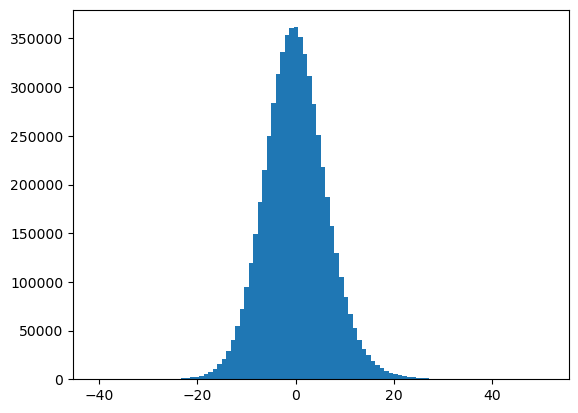

In [ ]:
import matplotlib.pyplot as plt
sigma = 1.5
Xt = sample_Xt_batch(Xmat, 100, sigma=sigma)
cross_terms = (Xt - Xmean) @ (Xmat - Xmean).t() / sigma ** 2
print(cross_terms.mean())
print(cross_terms.std())
plt.hist(cross_terms.flatten().numpy(), bins=100)
plt.show()

In [ ]:
plt.figure()
plt.hist(cross_terms.flatten().exp(), bins=100)
plt.show()

### Distance structure between noised sample and the dataset

In [133]:

for sigma in [0.02, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(Xmat, 5000, sigma=sigma)
    distmat = torch.cdist(Xt, Xmat, p=2)
    # print(f"sigma={sigma}, dist max={distmat.max().item()}, min={distmat.min().item()}, mean={distmat.mean().item()}, median={distmat.median().item()}, dist std={distmat.std().item()}")
    print(f"sigma={sigma}", end="")
    for func, name in [
                      (torch.min, "min"),
                      (torch.max, "max"),
                      (torch.median, "median"), 
                      (torch.mean, "mean"), 
                      (torch.std, "std"),]:
        if func in [torch.median, torch.min, torch.max]:
            stats_vec = func(distmat, dim=1).values
        else:
            stats_vec = func(distmat, dim=1)
        print(f" {name}={stats_vec.mean().item():.3f}", end="")
    print()

sigma=0.02 min=0.560 max=14.966 median=10.187 mean=10.177 std=1.203
sigma=0.1 min=2.799 max=15.220 median=10.567 mean=10.563 std=1.152
sigma=0.2 min=5.599 max=15.977 median=11.633 mean=11.639 std=1.043
sigma=0.5 min=13.994 max=20.584 median=17.315 mean=17.337 std=0.722
sigma=0.7 min=19.578 max=24.783 median=22.079 mean=22.101 std=0.585
sigma=1.0 min=27.978 max=31.962 median=29.783 mean=29.803 std=0.467
sigma=1.5 min=41.869 max=44.909 median=43.188 mean=43.203 std=0.372
sigma=2.0 min=55.741 max=58.381 median=56.893 mean=56.906 std=0.327
sigma=5.0 min=139.274 max=141.470 median=140.293 mean=140.300 std=0.269
sigma=10.0 min=279.070 max=281.205 median=280.100 mean=280.103 std=0.260


In [134]:
for sigma in [0.02, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(Xmat, 5000, sigma=sigma)
    distmat = torch.cdist(Xt, Xmat, p=2)**2 / sigma**2
    # print(f"sigma={sigma}, dist max={distmat.max().item()}, min={distmat.min().item()}, mean={distmat.mean().item()}, median={distmat.median().item()}, dist std={distmat.std().item()}")
    print(f"sigma={sigma}", end="")
    for func, name in [
                      (torch.min, "min"),
                      (torch.max, "max"),
                      (torch.median, "median"), 
                      (torch.mean, "mean"), 
                      (torch.std, "std"),]:
        if func in [torch.median, torch.min, torch.max]:
            stats_vec = func(distmat, dim=1).values
        else:
            stats_vec = func(distmat, dim=1)
        print(f" {name}={stats_vec.mean().item():.3f}", end="")
    print()

sigma=0.02 min=784.551 max=560838.312 median=261012.422 mean=264108.469 std=59908.164
sigma=0.1 min=783.721 max=23184.207 median=11197.188 mean=11323.918 std=2393.802
sigma=0.2 min=785.163 max=6393.518 median=3389.556 mean=3420.610 std=601.504
sigma=0.5 min=784.056 max=1694.463 median=1201.162 mean=1206.284 std=99.747
sigma=0.7 min=783.360 max=1253.478 median=996.236 mean=998.823 std=52.649
sigma=1.0 min=782.559 max=1021.553 median=887.965 mean=889.335 std=27.797
sigma=1.5 min=780.760 max=898.255 median=830.777 mean=831.457 std=14.313
sigma=2.0 min=777.607 max=852.956 median=809.997 mean=810.398 std=9.325
sigma=5.0 min=776.258 max=800.988 median=787.694 mean=787.769 std=3.038
sigma=10.0 min=779.273 max=791.248 median=785.029 mean=785.048 std=1.462


### Statistics of SoftMax function inf DeltaGMM score

In [142]:
print("Sample probing points from original dataset + noise")
for sigma in [0.02, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(Xmat, 5000, sigma=sigma)
    distmat = torch.cdist(Xt, Xmat, p=2)
    weights = F.softmax(-distmat**2 / (2 * sigma**2), dim=1)
    weights_sorted = torch.sort(weights, dim=1, descending=True).values
    cumulative_sum = torch.cumsum(weights_sorted, dim=1)
    min_elem999 = torch.argmax((cumulative_sum > 0.999).float(), dim=1) + 1
    min_elem99 = torch.argmax((cumulative_sum > 0.99).float(), dim=1) + 1
    min_elem90 = torch.argmax((cumulative_sum > 0.90).float(), dim=1) + 1
    min_elem80 = torch.argmax((cumulative_sum > 0.80).float(), dim=1) + 1
    min_elem50 = torch.argmax((cumulative_sum > 0.50).float(), dim=1) + 1
    print(f"sigma={sigma} # of sample for pcent weight", end="")
    for numvec, name in [
                      (min_elem50, "50%"),
                      (min_elem80, "80%"),
                      (min_elem90, "90%"),
                        (min_elem99, "99%"),
                        (min_elem999, "99.9%"),
                        ]:
        # if func in [torch.median, torch.min, torch.max]:
        stats = torch.median(numvec, dim=0).values
        print(f" {name}={stats.item():.0f}", end="")
    print()

Sample probing points from original dataset + noise
sigma=0.02 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=0.1 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=0.2 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=0.5 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=0.7 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=1.0 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=3 99.9%=11
sigma=1.5 # of sample for pcent weight 50%=4 80%=27 90%=72 99%=593 99.9%=2208
sigma=2.0 # of sample for pcent weight 50%=49 80%=394 90%=1006 99%=5987 99.9%=15452
sigma=2.5 # of sample for pcent weight 50%=262 80%=1741 90%=3894 99%=16352 99.9%=31546
sigma=3.0 # of sample for pcent weight 50%=797 80%=4281 90%=8507 99%=26963 99.9%=42734
sigma=4.0 # of sample for pcent weight 50%=2636 80%=10705 90%=18383 99%=41050 99.9%=53097
sigma=5.0 # of sample for pcent weight 50%=4970 80%=16894 90%=26323 99%=48086 99.9%=56621
sigm

In [141]:
print("Sample probing points from Gaussian approx of data + noise")
for sigma in [0.02, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 10.0]:
    X0_gauss = torch.randn([2000, Xmean.shape[0]], device=device) @ Xcov_half + Xmean
    Xt = X0_gauss + sigma * torch.randn_like(X0_gauss)
    distmat = torch.cdist(Xt, Xmat, p=2)
    weights = F.softmax(-distmat**2 / (2 * sigma**2), dim=1)
    weights_sorted = torch.sort(weights, dim=1, descending=True).values
    cumulative_sum = torch.cumsum(weights_sorted, dim=1)
    min_elem999 = torch.argmax((cumulative_sum > 0.999).float(), dim=1) + 1
    min_elem99 = torch.argmax((cumulative_sum > 0.99).float(), dim=1) + 1
    min_elem90 = torch.argmax((cumulative_sum > 0.90).float(), dim=1) + 1
    min_elem80 = torch.argmax((cumulative_sum > 0.80).float(), dim=1) + 1
    min_elem50 = torch.argmax((cumulative_sum > 0.50).float(), dim=1) + 1
    print(f"sigma={sigma} # of sample for pcent weight", end="")
    for numvec, name in [
                      (min_elem50, "50%"),
                      (min_elem80, "80%"),
                      (min_elem90, "90%"),
                      (min_elem99, "99%"),
                      (min_elem999, "99.9%"),
                        ]:
        # if func in [torch.median, torch.min, torch.max]:
        stats = torch.median(numvec, dim=0).values
        print(f" {name}={stats.item():.0f}", end="")
    print()

sigma=0.02 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=0.1 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=0.2 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=0.5 # of sample for pcent weight 50%=1 80%=1 90%=2 99%=3 99.9%=6
sigma=0.7 # of sample for pcent weight 50%=1 80%=2 90%=3 99%=10 99.9%=29
sigma=1.0 # of sample for pcent weight 50%=2 80%=6 90%=13 99%=92 99.9%=365
sigma=1.5 # of sample for pcent weight 50%=10 80%=76 90%=207 99%=1599 99.9%=5124
sigma=2.0 # of sample for pcent weight 50%=73 80%=590 90%=1453 99%=7923 99.9%=18585
sigma=2.5 # of sample for pcent weight 50%=343 80%=2144 90%=4616 99%=17819 99.9%=33004
sigma=3.0 # of sample for pcent weight 50%=882 80%=4658 90%=9107 99%=27806 99.9%=43383
sigma=4.0 # of sample for pcent weight 50%=2707 80%=11016 90%=18802 99%=41170 99.9%=53140
sigma=5.0 # of sample for pcent weight 50%=5047 80%=16982 90%=26348 99%=48182 99.9%=56643
sigma=10.0 # of sample for pcent weight 50%=1439

Observation:
* For MNIST dataset, at sigma level $\sigma<=0.7$ effectively the delta GMM score is generated by a single data point! 
 Kind of make sense that at this moment the Gaussian approximation fails miserabley. 
* If we sample probing points from a Gaussian, the score is slightly more distributed, at lower $\sigma$ level it still has multiple source of influence. 

### Radius of point cloud and distribution

In [36]:
torch.trace(Xcov).sqrt()

tensor(7.2618, device='cuda:0')

In [37]:
(Xmat - Xmean).pow(2).sum(dim=1).mean().sqrt()

tensor(7.2612, device='cuda:0')

In [28]:
rad_vec = (Xmat - Xmean).pow(2).sum(dim=1).sqrt()
print(rad_vec.max())
print(rad_vec.min())
print(rad_vec.mean())
print(rad_vec.std())

tensor(12.2324, device='cuda:0')
tensor(5.2739, device='cuda:0')
tensor(7.1944, device='cuda:0')
tensor(0.9824, device='cuda:0')


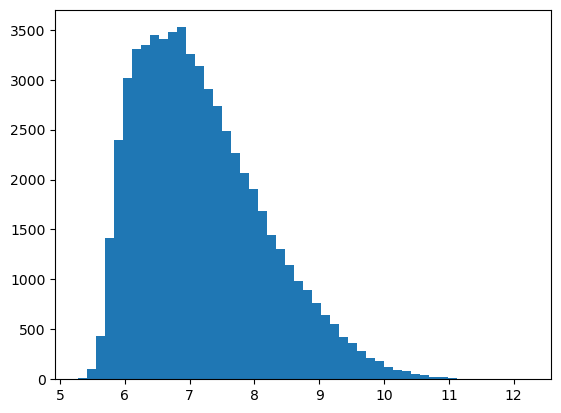

In [33]:
import matplotlib.pyplot as plt
plt.hist(rad_vec.cpu(),50)
plt.show()

In [29]:
rad_vec.mean()

tensor(7.1944, device='cuda:0')

In [64]:
distmat = torch.cdist(Xmat, Xmat, p=2)

In [70]:
print(distmat.max())
print(distmat.mean())

tensor(16.8758, device='cuda:0')
tensor(10.1686, device='cuda:0')


## EDM vs Analytical Score

### Set up the model config

In [13]:
import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
from train_edm import edm_sampler
from train_edm import EDM
from train_edm import create_model

In [14]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--expr", type=str, default="sampling", help="experiment name")
parser.add_argument("--dataset", type=str, default="mnist")
parser.add_argument('--seed', default=42, type=int, help='global seed')
parser.add_argument("--img_size", type=int, default=32)
parser.add_argument("--model_paths", default='', type=str, help='model paths')
# EDM models parameters
parser.add_argument('--sigma_min', default=0.002, type=float, help='sigma_min')
parser.add_argument('--sigma_max', default=80.0, type=float, help='sigma_max')
parser.add_argument('--rho', default=7., type=float, help='Schedule hyper-parameter')
parser.add_argument('--sigma_data', default=0.5, type=float, help='sigma_data used in EDM for c_skip and c_out')
# Sampling parameters
parser.add_argument('--total_steps', default=18, type=int, help='total_steps')
parser.add_argument("--eval_batch_size", type=int, default=64)
parser.add_argument("--fid_batch_size", type=int, default=64)
parser.add_argument("--sample_mode", type=str, default='fid', help='sample mode')
parser.add_argument('--num_fid_sample', default=10000, type=int, help='num_fid_sample')
parser.add_argument('--t_path', default='./CIFAR-10-images/train', type=str, help='source clean image path')
parser.add_argument('--begin_ckpt', default=0, type=int, help='begin_ckpt')
# Model architecture
parser.add_argument('--model_channels', default=64, type=int, help='model_channels')
parser.add_argument('--channel_mult', default=[1,2,2,2], type=int, nargs='+', help='channel_mult')
parser.add_argument('--attn_resolutions', default=[], type=int, nargs='+', help='attn_resolutions')
parser.add_argument('--layers_per_block', default=4, type=int, help='num_blocks')

config = parser.parse_args([])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.device = device
channels = {'mnist': 1, 'cifar10': 3}
config.channels = channels[config.dataset]

In [15]:
# config for MNIST
config.channel_mult = [1, 2, 3, 4]
config.model_channels = 16
config.attn_resolutions = [0,]
config.layers_per_block = 1
config.num_fid_sample = 5000
config.fid_batch_size = 1024

In [16]:
config

Namespace(expr='sampling', dataset='mnist', seed=42, img_size=32, model_paths='', sigma_min=0.002, sigma_max=80.0, rho=7.0, sigma_data=0.5, total_steps=18, eval_batch_size=64, fid_batch_size=1024, sample_mode='fid', num_fid_sample=5000, t_path='./CIFAR-10-images/train', begin_ckpt=0, model_channels=16, channel_mult=[1, 2, 3, 4], attn_resolutions=[0], layers_per_block=1, device=device(type='cuda'), channels=1)

In [17]:
def load_create_edm(config, model_path):
    # model_path = f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_75000.pth"
    unet = create_model(config)
    edm = EDM(model=unet, cfg=config)
    checkpoint = torch.load(model_path, map_location=device)
    # logger.info(f"loaded model: {model_name}")
    edm.model.load_state_dict(checkpoint)
    for param in edm.model.parameters():
        param.requires_grad = False
    edm.model.eval()
    return edm

model_path = f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_75000.pth"
unet = create_model(config)
edm = EDM(model=unet, cfg=config)
checkpoint = torch.load(model_path, map_location=device)
# logger.info(f"loaded model: {model_name}")
edm.model.load_state_dict(checkpoint)
for param in edm.model.parameters():
    param.requires_grad = False
edm.model.eval();

### Load and Examine the EDM trained model w.r.t. scores

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.utils import save_image

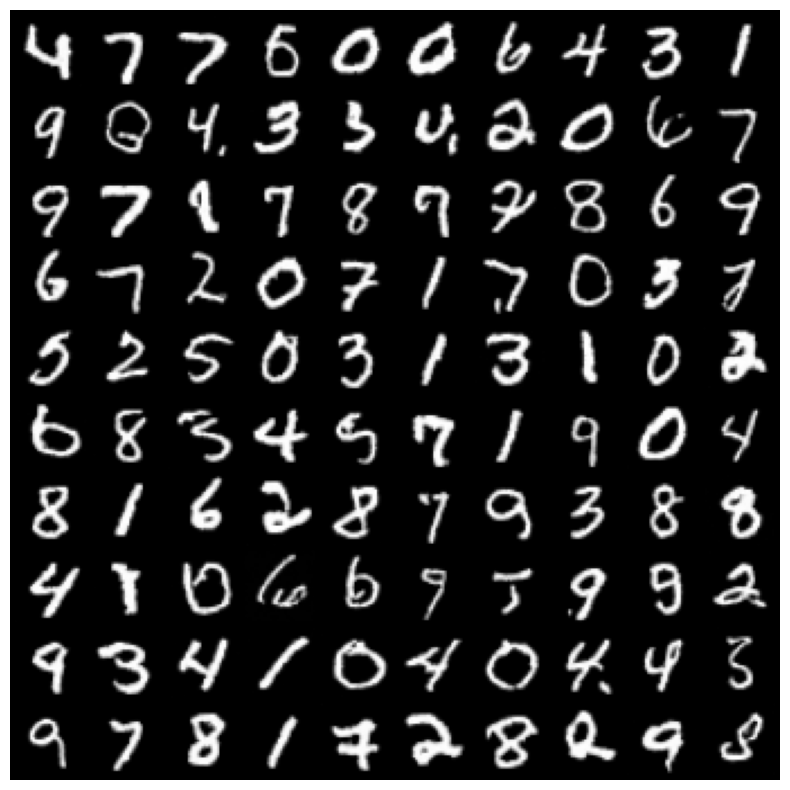

In [224]:
fid_batch_size = 100
with torch.no_grad():
    noise = torch.randn([fid_batch_size, config.channels, config.img_size, config.img_size],
                        generator=torch.cuda.manual_seed(config.seed), device=config.device)
    samples = edm_sampler(edm, noise, num_steps=config.total_steps, use_ema=False).detach().cpu()
    samples.mul_(0.5).add_(0.5)
samples = torch.clamp(samples, 0., 1.).cpu()
# samples = np.clip(samples.permute(0, 2, 3, 1).cpu().numpy() * 255., 0, 255).astype(np.uint8)
# samples = samples.reshape((-1, config.img_size, config.img_size, config.channels))
# all_samples.append(samples)

plt.figure(figsize=(10, 10))
plt.imshow((make_grid(samples*255.0, nrow=10).permute(1, 2, 0)).numpy().astype(np.uint8))
plt.axis('off')
plt.show()

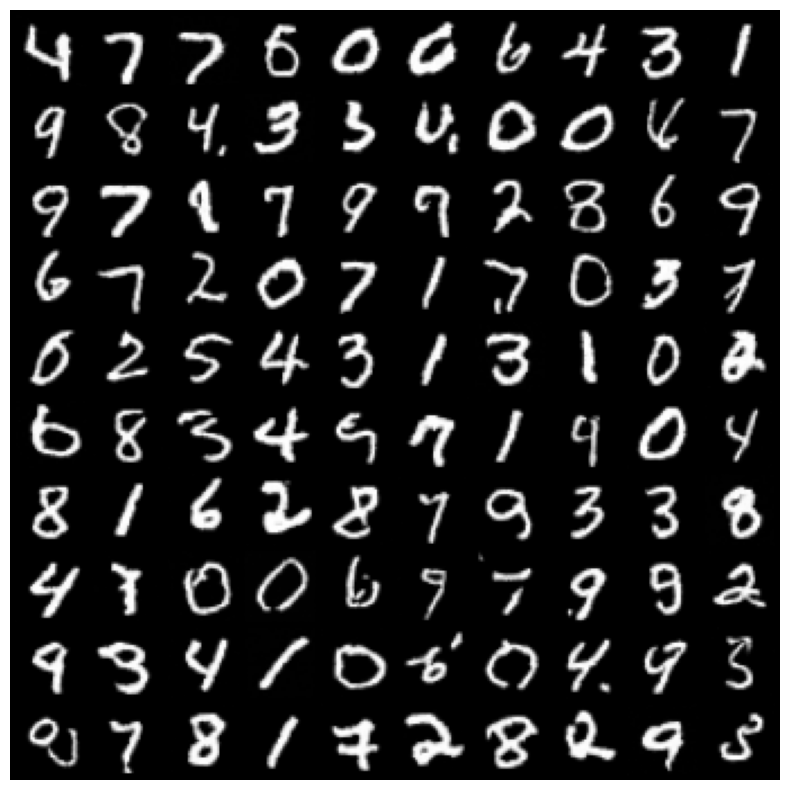

In [174]:
plt.figure(figsize=(10, 10))
plt.imshow((make_grid(samples*255.0, nrow=10).permute(1, 2, 0)).numpy().astype(np.uint8))
plt.axis('off')
plt.show()

### Load Dataset in EDM convention

In [12]:
transform = transforms.Compose([
    torchvision.transforms.Resize(32), # config.img_size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Download and load the MNIST dataset
train_edm_dataset = torchvision.datasets.MNIST(root='~/Datasets', train=True, transform=transform, download=False)
test_edm_dataset = torchvision.datasets.MNIST(root='~/Datasets', train=False, transform=transform)

edm_Xtsr = torch.stack([train_edm_dataset[i][0] for i in range(len(train_edm_dataset))])
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).cuda()
edm_Xtsr_test = torch.stack([test_edm_dataset[i][0] for i in range(len(test_edm_dataset))])
edm_Xmat_test = edm_Xtsr_test.view(edm_Xtsr_test.shape[0], -1)
ytsr_test = torch.tensor(test_edm_dataset.targets)

edm_imgshape = tuple(edm_Xtsr.shape[1:])

/tmp/ipykernel_3958148/2316927916.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytsr_test = torch.tensor(test_edm_dataset.targets)


In [18]:
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )

eigvals, eigvecs = torch.linalg.eigh(edm_Xcov)
eigvals = torch.flip(eigvals, dims=(0,))
eigvecs = torch.flip(eigvecs, dims=(1,))
print(eigvals.shape, eigvecs.shape)
print(eigvals[0:10].sqrt())

torch.Size([1024]) torch.Size([1024, 1024])
tensor([5.0782, 4.2297, 3.9882, 3.7294, 3.5631, 3.3024, 2.9141, 2.6671, 2.6480,
        2.4165], device='cuda:0')


### Comparing EDM score to Approximators

In [19]:
def explained_var(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum() / vec1.pow(2).sum()

def explained_var_vec(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum(dim=-1) / vec1.pow(2).sum(dim=-1)


In [26]:
edm = load_create_edm(config, f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_50000.pth")
device = "cuda"
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()
print("Explaining GMM score with EDM and other analytical scores")
# print(Xcov.shape)
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(edm_Xmat, 2000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    score_edm = (edm_Dt.view(Xt.shape) - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    for name, score in [("EDM", score_edm), 
                        ("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        # ("gmm delta", score_gmm_Xt),
                        ]:
        exp_var_vec = explained_var_vec(score_gmm_Xt, score)
        exp_var_rev_vec = explained_var_vec(score, score_gmm_Xt)
        print(f" {name}\tExp.Var.{exp_var_vec.mean().item()} "\
              f"\t rev Exp.Var.={exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
    

Explaining GMM score with EDM and other analytical scores
sigma=0.01
 EDM	Exp.Var.0.7952994704246521 	 rev Exp.Var.=0.7334059476852417 
 mean isotropic	Exp.Var.-2230.1689453125 	 rev Exp.Var.=0.0005548036424443126 
 mean + std isotropic	Exp.Var.-0.0017408480634912848 	 rev Exp.Var.=-220.32415771484375 
 gaussian	Exp.Var.0.3091558516025543 	 rev Exp.Var.=-0.21917754411697388 
 gaussian regularize	Exp.Var.0.3206830620765686 	 rev Exp.Var.=-4.7363667488098145 
 gaussian 1st expansion	Exp.Var.-33355066245120.0 	 rev Exp.Var.=-3.5762788286319847e-09 
 gaussian 2nd expansion	Exp.Var.-1.4504099845557398e+24 	 rev Exp.Var.=0.0 
sigma=0.02
 EDM	Exp.Var.0.8525344729423523 	 rev Exp.Var.=0.8267999887466431 
 mean isotropic	Exp.Var.-561.0957641601562 	 rev Exp.Var.=0.0019521499052643776 
 mean + std isotropic	Exp.Var.-0.007768555078655481 	 rev Exp.Var.=-54.45782470703125 
 gaussian	Exp.Var.0.47179388999938965 	 rev Exp.Var.=-0.09972647577524185 
 gaussian regularize	Exp.Var.0.4572310745716095 	 r

In [27]:
edm = load_create_edm(config, f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_50000.pth")
device = "cuda"
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()

print("Explaining EDM score with GMM and other analytical scores")
# print(Xcov.shape)
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 60.0, 80.0]:
    Xt = sample_Xt_batch(edm_Xmat, 2000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    score_edm = (edm_Dt.view(Xt.shape) - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    for name, score in [("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gmm delta", score_gmm_Xt),
                        ]:
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        print(f" {name}\tExp.Var. {exp_var_vec.mean().item()} "\
              f"\t rev Exp.Var. {exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
    

Explaining EDM score with GMM and other analytical scores
sigma=0.01
 mean isotropic	Exp.Var. -3002.649169921875 	 rev Exp.Var. 0.0007472772849723697 
 mean + std isotropic	Exp.Var. -0.0019584225956350565 	 rev Exp.Var. -173.57916259765625 
 gaussian	Exp.Var. 0.3078383207321167 	 rev Exp.Var. 0.03067723661661148 
 gaussian regularize	Exp.Var. 0.37404170632362366 	 rev Exp.Var. -3.2203571796417236 
 gaussian 1st expansion	Exp.Var. -46158391017472.0 	 rev Exp.Var. -9.566545777772717e-09 
 gaussian 2nd expansion	Exp.Var. -2.026796229306928e+24 	 rev Exp.Var. 0.0 
 gmm delta	Exp.Var. 0.7235814332962036 	 rev Exp.Var. 0.7900484800338745 
sigma=0.02
 mean isotropic	Exp.Var. -674.2861938476562 	 rev Exp.Var. 0.0024838820099830627 
 mean + std isotropic	Exp.Var. -0.008553408086299896 	 rev Exp.Var. -46.74761962890625 
 gaussian	Exp.Var. 0.5325754880905151 	 rev Exp.Var. 0.1709420531988144 
 gaussian regularize	Exp.Var. 0.519999086856842 	 rev Exp.Var. -0.292161762714386 
 gaussian 1st expansio

In [226]:
edm = load_create_edm(config, f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_75000.pth")
    
device = "cuda"
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()

# print(Xcov.shape)
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, ]:
    Xt = sample_Xt_batch(edm_Xmat, 2000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    score_edm = (edm_Dt.view(Xt.shape) - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    for name, score in [("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        # ("gaussian regularize", score_gaussian_reg_Xt),
                        # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gmm delta", score_gmm_Xt),
                        ]:
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        print(f" {name}\tExp.Var. {exp_var_vec.mean().item()} "\
              f"\t rev Exp.Var. {exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
    

sigma=0.01
 mean isotropic	Exp.Var. -2917.1806640625 	 rev Exp.Var. 0.000609740789514035 
 mean + std isotropic	Exp.Var. -0.002521313726902008 	 rev Exp.Var. -177.3274383544922 
 gaussian	Exp.Var. 0.30414825677871704 	 rev Exp.Var. 0.025901729241013527 
 gmm delta	Exp.Var. 0.7476081848144531 	 rev Exp.Var. 0.8042603135108948 
sigma=0.02
 mean isotropic	Exp.Var. -663.2575073242188 	 rev Exp.Var. 0.00254442123696208 
 mean + std isotropic	Exp.Var. -0.008038296364247799 	 rev Exp.Var. -46.97417449951172 
 gaussian	Exp.Var. 0.5371341109275818 	 rev Exp.Var. 0.17284540832042694 
 gmm delta	Exp.Var. 0.8321826457977295 	 rev Exp.Var. 0.8578644394874573 
sigma=0.05
 mean isotropic	Exp.Var. -98.03926086425781 	 rev Exp.Var. 0.014159111306071281 
 mean + std isotropic	Exp.Var. -0.0463344044983387 	 rev Exp.Var. -7.816861629486084 
 gaussian	Exp.Var. 0.6508159637451172 	 rev Exp.Var. 0.46431541442871094 
 gmm delta	Exp.Var. 0.8948584198951721 	 rev Exp.Var. 0.9052230715751648 
sigma=0.1
 mean iso

* Gaussian explains 30% var of edm, but edm only explains 0.03 var of Gaussian, showing that Gaussian has more total variance than edm?
* GMM delta explains 74% of var of EDM score, but EDM score explains 80% of GMM delta, showing that EDM score has higher variance than GMM?

In [229]:
edm = load_create_edm(config, f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_100000.pth")
device = "cuda"
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()

# print(Xcov.shape)
for sigma in [0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(edm_Xmat, 5000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    score_edm = (edm_Dt.view(Xt.shape) - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    for name, score in [("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        # ("gaussian regularize", score_gaussian_reg_Xt),
                        # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gmm delta", score_gmm_Xt),
                        ]:
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        print(f" {name}\tExp.Var. {exp_var_vec.mean().item()} "\
              f"\t rev Exp.Var. {exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
    

sigma=0.002
 mean isotropic	Exp.Var. -270935.34375 	 rev Exp.Var. -0.00014012503379490227 
 mean + std isotropic	Exp.Var. -0.00288417492993176 	 rev Exp.Var. -1275.8887939453125 
 gaussian	Exp.Var. -199.47557067871094 	 rev Exp.Var. -0.004285365808755159 
 gmm delta	Exp.Var. -1.4877269268035889 	 rev Exp.Var. 0.46937304735183716 
sigma=0.005
 mean isotropic	Exp.Var. -15975.1865234375 	 rev Exp.Var. 1.7665957784629427e-05 
 mean + std isotropic	Exp.Var. -0.0018205890664830804 	 rev Exp.Var. -549.6715087890625 
 gaussian	Exp.Var. -17.720664978027344 	 rev Exp.Var. -0.028436288237571716 
 gmm delta	Exp.Var. 0.5209484696388245 	 rev Exp.Var. 0.7294464111328125 
sigma=0.01
 mean isotropic	Exp.Var. -2898.823486328125 	 rev Exp.Var. 0.0006703943945467472 
 mean + std isotropic	Exp.Var. -0.0022639480885118246 	 rev Exp.Var. -176.62918090820312 
 gaussian	Exp.Var. 0.31109553575515747 	 rev Exp.Var. 0.033941105008125305 
 gmm delta	Exp.Var. 0.7558889389038086 	 rev Exp.Var. 0.8103107213973999 
s

In [230]:
edm = load_create_edm(config, f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_125000.pth")
device = "cuda"
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()

# print(Xcov.shape)
for sigma in [0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(edm_Xmat, 5000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    score_edm = (edm_Dt.view(Xt.shape) - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    for name, score in [("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        # ("gaussian regularize", score_gaussian_reg_Xt),
                        # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gmm delta", score_gmm_Xt),
                        ]:
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        print(f" {name}\tExp.Var. {exp_var_vec.mean().item()} "\
              f"\t rev Exp.Var. {exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
    

sigma=0.002
 mean isotropic	Exp.Var. -250848.25 	 rev Exp.Var. -0.00017609259521123022 
 mean + std isotropic	Exp.Var. -0.0030935064423829317 	 rev Exp.Var. -1360.3707275390625 
 gaussian	Exp.Var. -188.32606506347656 	 rev Exp.Var. -0.0050946385599672794 
 gmm delta	Exp.Var. -1.2682924270629883 	 rev Exp.Var. 0.4851462244987488 
sigma=0.005
 mean isotropic	Exp.Var. -15587.1005859375 	 rev Exp.Var. 1.6138981663971208e-05 
 mean + std isotropic	Exp.Var. -0.0017717143055051565 	 rev Exp.Var. -557.4221801757812 
 gaussian	Exp.Var. -16.48112678527832 	 rev Exp.Var. -0.030194884166121483 
 gmm delta	Exp.Var. 0.5433433651924133 	 rev Exp.Var. 0.7349072098731995 
sigma=0.01
 mean isotropic	Exp.Var. -2902.986328125 	 rev Exp.Var. 0.0007180653628893197 
 mean + std isotropic	Exp.Var. -0.002041255822405219 	 rev Exp.Var. -176.2422637939453 
 gaussian	Exp.Var. 0.31644853949546814 	 rev Exp.Var. 0.04024520888924599 
 gmm delta	Exp.Var. 0.7618592977523804 	 rev Exp.Var. 0.8147758841514587 
sigma=0.0

### EDM ~ GMM Synopsis table and plot

In [427]:
import pandas as pd
from tqdm import trange, tqdm
device = "cuda"
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()
df_col = []
for epoch in trange(25000, 1000000, 25000):
    print(f"epoch={epoch}")
    if epoch == 1000000: epoch -=1
    edm = load_create_edm(config, f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_{epoch}.pth")
    for sigma in [0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]:
        Xt = sample_Xt_batch(edm_Xmat, 5000, sigma=sigma)
        edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
        score_edm = (edm_Dt.view(Xt.shape) - Xt) / (sigma**2)
        score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
        score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
        score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
        score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
        score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
        score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
        score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
        # print(f"sigma={sigma}")
        for shortname, name, score in [("iso_mean","mean isotropic", score_mean_Xt), 
                            ("iso_meanstd","mean + std isotropic", score_mean_std_Xt), 
                            ("gauss","gaussian", score_gaussian_Xt), 
                            ("gauss_reg", "gaussian regularize", score_gaussian_reg_Xt),
                            # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                            # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                            ("gmm_delta","gmm delta", score_gmm_Xt),
                            ]:
            exp_var_vec = explained_var_vec(score_edm, score)
            exp_var_rev_vec = explained_var_vec(score, score_edm)
            # print(f" {name}\tExp.Var. {exp_var_vec.mean().item()} "\
            #     f"\t rev Exp.Var. {exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
            df_col.append({"edm_epoch": epoch, "sigma": sigma, "approximator": name, 
                           "expvar": exp_var_vec.mean().item(), "rev_expvar": exp_var_rev_vec.mean().item(),
                           "resratio": 1- exp_var_vec.mean().item(), "rev_resratio": 1- exp_var_rev_vec.mean().item(),})
df = pd.DataFrame(df_col)

  0%|                                                                                                            | 0/39 [00:00<?, ?it/s]

epoch=25000


  3%|██▌                                                                                                 | 1/39 [00:03<02:04,  3.29s/it]

epoch=50000


  5%|█████▏                                                                                              | 2/39 [00:06<02:01,  3.28s/it]

epoch=75000


  8%|███████▋                                                                                            | 3/39 [00:09<01:58,  3.28s/it]

epoch=100000


 10%|██████████▎                                                                                         | 4/39 [00:13<01:54,  3.28s/it]

epoch=125000


 13%|████████████▊                                                                                       | 5/39 [00:16<01:51,  3.28s/it]

epoch=150000


 15%|███████████████▍                                                                                    | 6/39 [00:19<01:48,  3.28s/it]

epoch=175000


 18%|█████████████████▉                                                                                  | 7/39 [00:22<01:45,  3.28s/it]

epoch=200000


 21%|████████████████████▌                                                                               | 8/39 [00:26<01:41,  3.28s/it]

epoch=225000


 23%|███████████████████████                                                                             | 9/39 [00:29<01:38,  3.28s/it]

epoch=250000


 26%|█████████████████████████▍                                                                         | 10/39 [00:32<01:35,  3.28s/it]

epoch=275000


 28%|███████████████████████████▉                                                                       | 11/39 [00:36<01:34,  3.39s/it]

epoch=300000


 31%|██████████████████████████████▍                                                                    | 12/39 [00:39<01:30,  3.35s/it]

epoch=325000


 33%|█████████████████████████████████                                                                  | 13/39 [00:43<01:26,  3.33s/it]

epoch=350000


 36%|███████████████████████████████████▌                                                               | 14/39 [00:46<01:22,  3.32s/it]

epoch=375000


 38%|██████████████████████████████████████                                                             | 15/39 [00:49<01:19,  3.31s/it]

epoch=400000


 41%|████████████████████████████████████████▌                                                          | 16/39 [00:52<01:15,  3.30s/it]

epoch=425000


 44%|███████████████████████████████████████████▏                                                       | 17/39 [00:56<01:12,  3.29s/it]

epoch=450000


 46%|█████████████████████████████████████████████▋                                                     | 18/39 [00:59<01:09,  3.29s/it]

epoch=475000


 49%|████████████████████████████████████████████████▏                                                  | 19/39 [01:02<01:05,  3.29s/it]

epoch=500000


 51%|██████████████████████████████████████████████████▊                                                | 20/39 [01:05<01:02,  3.29s/it]

epoch=525000


 54%|█████████████████████████████████████████████████████▎                                             | 21/39 [01:09<00:59,  3.32s/it]

epoch=550000


 56%|███████████████████████████████████████████████████████▊                                           | 22/39 [01:12<00:56,  3.33s/it]

epoch=575000


 59%|██████████████████████████████████████████████████████████▍                                        | 23/39 [01:16<00:53,  3.35s/it]

epoch=600000


 62%|████████████████████████████████████████████████████████████▉                                      | 24/39 [01:19<00:50,  3.36s/it]

epoch=625000


 64%|███████████████████████████████████████████████████████████████▍                                   | 25/39 [01:22<00:47,  3.36s/it]

epoch=650000


 67%|██████████████████████████████████████████████████████████████████                                 | 26/39 [01:26<00:43,  3.37s/it]

epoch=675000


 69%|████████████████████████████████████████████████████████████████████▌                              | 27/39 [01:29<00:40,  3.37s/it]

epoch=700000


 72%|███████████████████████████████████████████████████████████████████████                            | 28/39 [01:33<00:37,  3.38s/it]

epoch=725000


 74%|█████████████████████████████████████████████████████████████████████████▌                         | 29/39 [01:36<00:33,  3.38s/it]

epoch=750000


 77%|████████████████████████████████████████████████████████████████████████████▏                      | 30/39 [01:39<00:30,  3.38s/it]

epoch=775000


 79%|██████████████████████████████████████████████████████████████████████████████▋                    | 31/39 [01:43<00:27,  3.38s/it]

epoch=800000


 82%|█████████████████████████████████████████████████████████████████████████████████▏                 | 32/39 [01:46<00:23,  3.39s/it]

epoch=825000


 85%|███████████████████████████████████████████████████████████████████████████████████▊               | 33/39 [01:49<00:20,  3.39s/it]

epoch=850000


 87%|██████████████████████████████████████████████████████████████████████████████████████▎            | 34/39 [01:53<00:16,  3.39s/it]

epoch=875000


 90%|████████████████████████████████████████████████████████████████████████████████████████▊          | 35/39 [01:56<00:13,  3.39s/it]

epoch=900000


 92%|███████████████████████████████████████████████████████████████████████████████████████████▍       | 36/39 [02:00<00:10,  3.39s/it]

epoch=925000


 95%|█████████████████████████████████████████████████████████████████████████████████████████████▉     | 37/39 [02:03<00:06,  3.39s/it]

epoch=950000


 97%|████████████████████████████████████████████████████████████████████████████████████████████████▍  | 38/39 [02:06<00:03,  3.39s/it]

epoch=975000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [02:10<00:00,  3.34s/it]


In [428]:
import os
os.makedirs("Tables", exist_ok=True)
df.to_csv("Tables/mnist_edm_analy_approx_err.csv", index=False)

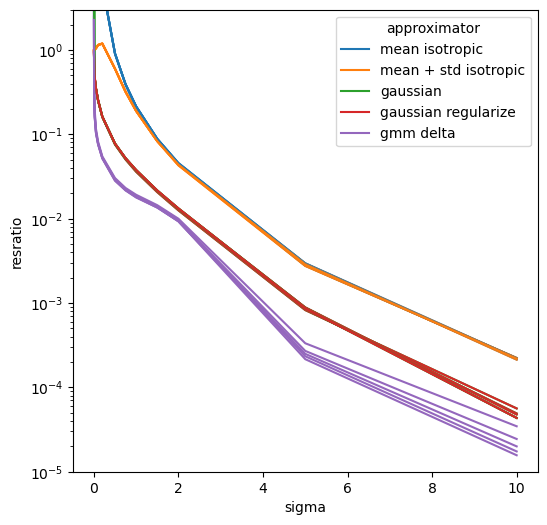

In [429]:
import seaborn as sns
plt.figure(figsize=(6, 6))
for epoch in [25000, 50000, 75000, 100000, 125000]:
    sns.lineplot(data=df[df.edm_epoch==epoch], x="sigma", y="resratio", 
                 hue="approximator",
                 legend=False if epoch != 25000 else True, )
plt.ylim([1E-5, 3])
# plt.xscale("log")
plt.yscale("log")
plt.show()


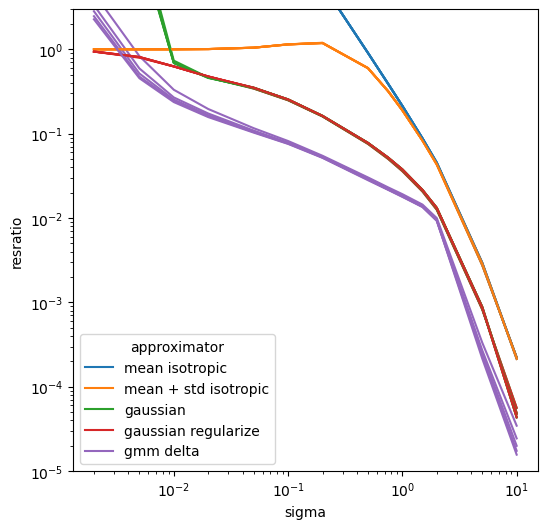

In [437]:
import seaborn as sns
plt.figure(figsize=(6, 6))
for epoch in [25000, 50000, 75000, 100000, 125000]:
    sns.lineplot(data=df[df.edm_epoch==epoch], x="sigma", y="resratio", 
                 hue="approximator",
                 legend=False if epoch != 25000 else True, )
plt.ylim([1E-5, 3])
plt.xscale("log")
plt.yscale("log")
plt.show()


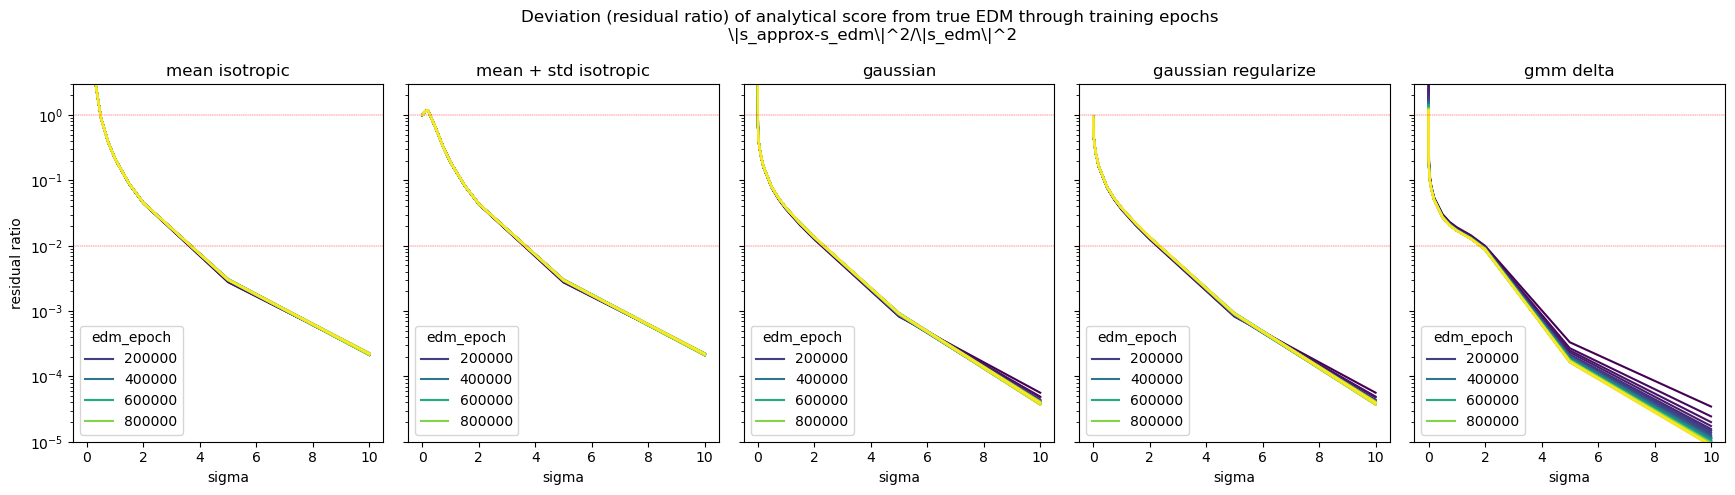

In [436]:
figh, axs = plt.subplots(1, 5,figsize=(17.5, 5), sharey=True, )
for i, approximator in enumerate(df.approximator.unique()):
    sns.lineplot(data=df[df.approximator==approximator], x="sigma", y="resratio", 
                    hue="edm_epoch", legend=True, palette="viridis", ax = axs[i])
    axs[i].set_title(approximator)
    axs[i].set_ylim([1E-5, 3])
    # plt.xscale("log")
    axs[i].set_yscale("log")
    axs[i].axhline(y=1E-2, color="red", linestyle="--", lw=0.3)
    axs[i].axhline(y=1, color="red", linestyle="--", lw=0.3)
    if i==0:
        axs[i].set_ylabel("residual ratio")
figh.suptitle("Deviation (residual ratio) of analytical score from true EDM through training epochs\n \|s_approx-s_edm\|^2/\|s_edm\|^2")
figh.tight_layout()
plt.show()

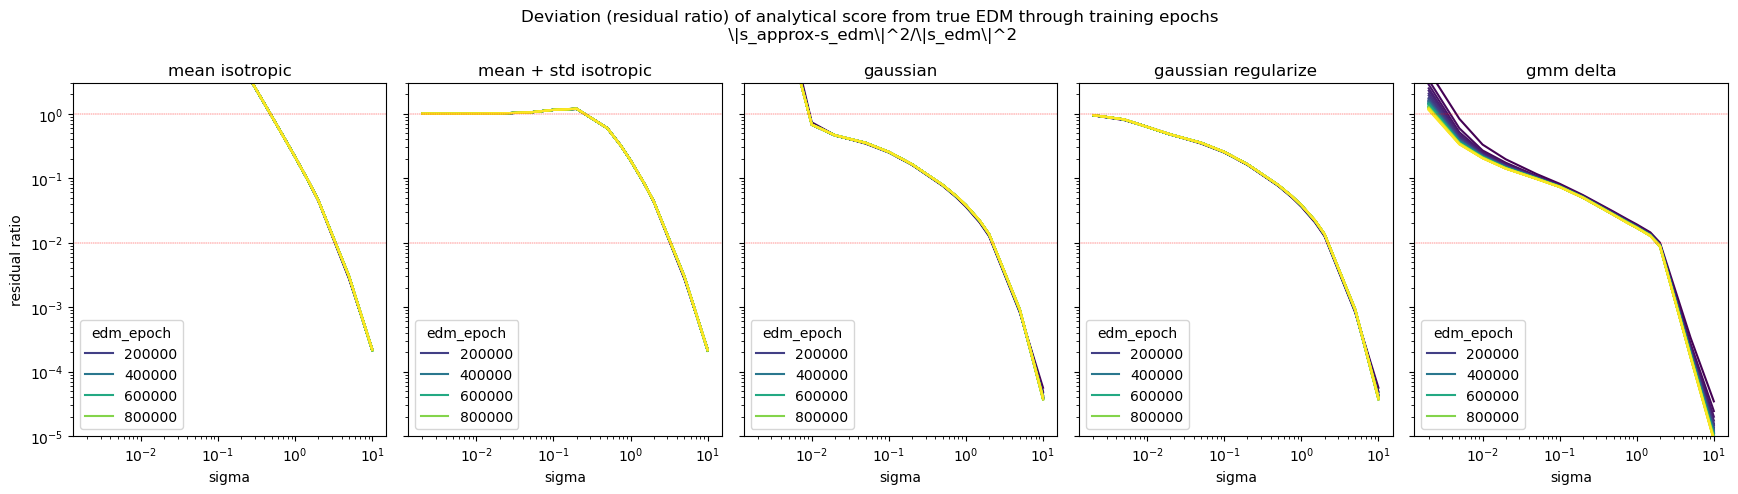

In [440]:
figh, axs = plt.subplots(1, 5,figsize=(17.5, 5), sharey=True, )
for i, approximator in enumerate(df.approximator.unique()):
    sns.lineplot(data=df[df.approximator==approximator], x="sigma", y="resratio", 
                    hue="edm_epoch", legend=True, palette="viridis", ax = axs[i])
    axs[i].set_title(approximator)
    axs[i].set_ylim([1E-5, 3])
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].axhline(y=1E-2, color="red", linestyle="--", lw=0.3)
    axs[i].axhline(y=1, color="red", linestyle="--", lw=0.3)
    if i==0:
        axs[i].set_ylabel("residual ratio")
figh.suptitle("Deviation (residual ratio) of analytical score from true EDM through training epochs\n \|s_approx-s_edm\|^2/\|s_edm\|^2")
figh.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
# for epoch in [25000, 50000, 75000, 100000, 125000]:
sns.lineplot(data=df, x="sigma", y="resratio", 
                 hue="edm_epoch", color="purple", style="approximator", 
                 legend=True, palette="inferno", )
plt.ylim([1E-5, 3])
# plt.xscale("log")
plt.yscale("log")
plt.show()

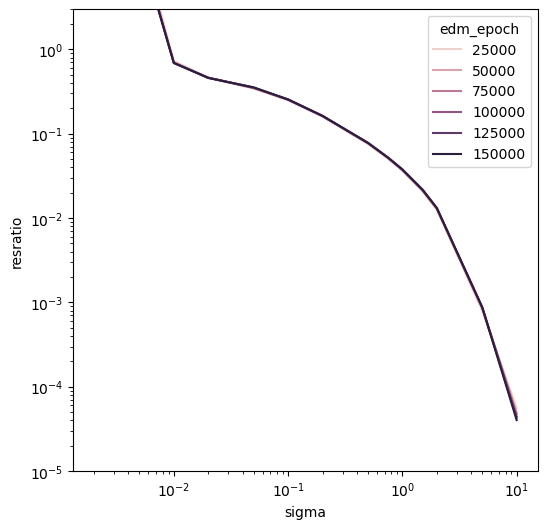

In [256]:
plt.figure(figsize=(6, 6))
# for epoch in [25000, 50000, 75000, 100000, 125000]:
sns.lineplot(data=df[df.approximator=="gaussian"], x="sigma", y="resratio", 
                 hue="edm_epoch", legend=True)
plt.ylim([1E-5, 3])
plt.xscale("log")
plt.yscale("log")
plt.show()

### Training Loss and FID

In [441]:
logfile = r"~/Github/mini_edm/exps/base_mnist_20240129-1342/std.log"


In [443]:
!pwd

/n/home12/binxuwang/Github/DiffusionMemorization/notebooks


In [445]:
import re
import pandas as pd

logfile = "/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/std.log"

# Define the regex pattern to extract the desired information
# pattern = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) - (\w+): (.*)"
pattern = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\s+(\w+)\s+-->\s+step:\s+(\d+),\s+current lr:\s+([\d.]+)\s+average loss:\s+([\d.]+);\s+batch loss:\s+([\d.]+)"

# Create empty lists to store the extracted information
timestamps = []
levels = []
messages = []
df_col = []
# Read the logfile line by line and extract the desired information
with open(logfile, "r") as file:
    for line in file:
        match = re.match(pattern, line)
        if match:
            timestamp = match.group(1)
            level = match.group(2)
            step = match.group(3)
            learning_rate = match.group(4)
            average_loss = match.group(5)
            batch_loss = match.group(6)
            df_col.append({"timestamp": timestamp, "level": level, "step": int(step),
                            "learning_rate": float(learning_rate), "average_loss": float(average_loss),
                            "batch_loss": float(batch_loss),})

# Create a pandas dataframe from the extracted information
df = pd.DataFrame(df_col)

# Display the dataframe
print(df.head())


             timestamp level  step  learning_rate  average_loss  batch_loss
0  2024-01-29 13:43:03  INFO     0        0.00000      1.833650    1.833650
1  2024-01-29 13:43:27  INFO   500        0.00002      1.697529    1.329292
2  2024-01-29 13:43:51  INFO  1000        0.00004      1.328696    0.695399
3  2024-01-29 13:44:15  INFO  1500        0.00006      1.073665    0.446776
4  2024-01-29 13:44:39  INFO  2000        0.00008      0.896503    0.295767


In [517]:
df.step[(df.batch_loss< 0.1)].min()

18000

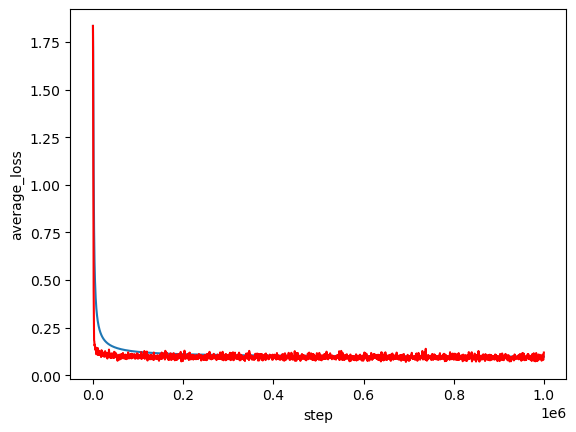

In [448]:
sns.lineplot(data=df, x="step", y="average_loss", legend=True)
sns.lineplot(data=df, x="step", y="batch_loss", legend=True, color="red")
plt.show()

In [ ]:
print(f"epoch={epoch}")
edm = load_create_edm(config, f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_{epoch}.pth")
for sigma in [0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]:
    # Xt = sample_Xt_batch(edm_Xmat, 5000, sigma=sigma)
    grid_Xs 
    Xt = ...
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    score_edm = (edm_Dt.view(Xt.shape) - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)

In [ ]:
import numpy as np
from scipy.spatial import Delaunay

def simplex_grid(points, n):
    tri = Delaunay(points)
    simplex = tri.simplices
    barycentric = np.random.rand(n, 3)
    barycentric = barycentric / np.sum(barycentric, axis=1)[:, np.newaxis]
    grid_points = np.einsum('ijk,ik->ij', points[simplex], barycentric)
    return grid_points

# Assuming edm_Xmat is a numpy array of shape (3, n)
grid_points = simplex_grid(edm_Xmat, n=100)
print(grid_points)
